# Example 

## Playing with my own gnn

In [2]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

from layers.hyp_layer import HyperbolicGraphConvolution as HypGCN
from manifold.poincare import PoincareBall
from dataHandler import ParticleDataset
from optimizer.radam import RiemannianAdam

import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch
#plt.style.use('dark_background')

ModuleNotFoundError: No module named 'temp_layers'

In [15]:
manifold = PoincareBall() #initialise the manifold

train = ParticleDataset('data/test','background')
#train = DataLoader(train, batch_size=4, shuffle=True,num_workers=128)

# use 20% of training data for validation
train_set_size = int(len(train) * 0.8)
valid_set_size = len(train) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(train, [train_set_size, valid_set_size], generator=seed)
train_set = DataLoader(train_set,batch_size=4,num_workers=128)
valid_set = DataLoader(valid_set,batch_size=4,num_workers=128)

test = ParticleDataset('data/test','background')
test_set = DataLoader(test, batch_size=4,num_workers=128)

In [3]:
#activation = torch.tanh
'''
class hgcn(torch.nn.Module):
    def __init__(self, manifold, _in, _h1, _out):
        super().__init__()
        self.hconv1 = HypGCN(manifold, _in-1, _h1)
        self.hconv2 = HypGCN(manifold, _h1, _h1, use_activation=True, use_aggregation=False)
        self.hconv3 = HypGCN(manifold, _h1, _h1, use_activation=True, use_aggregation=True)
        self.hconv4 = HypGCN(manifold, _h1, _out)
                
    def forward(self,data):
        x, edge_index = manifold.lorentz_to_poincare(data.x), data.edge_index
        
        x = self.hconv1(x, edge_index)
        x = self.hconv2(x, edge_index)
        x = self.hconv3(x, edge_index)
        x = self.hconv4(x, edge_index)
        
        return x
'''    
class hgcn(torch.nn.Module):
    def __init__(self, manifold, _in, _h1, _out):
        super().__init__()
        self.manifold = manifold
        self.hconv1 = HypGCN(manifold, _in-1, _h1, use_activation=True)
        self.hconv_2 = HypGCN(manifold, _h1, _h1, use_activation=True)
        self.hconv_3 = HypGCN(manifold, _h1, _h1, use_activation=True)
        self.hconv2 = HypGCN(manifold, _h1, _h1, use_activation=True,
            use_aggregation=True)
        self.hconv3 = HypGCN(manifold, _h1, _h1, use_activation=True,
            use_aggregation=True)
        self.hconv4 = HypGCN(manifold, _h1, _out)

    def forward(self, data):
        x = self.manifold.lorentz_to_poincare(data.x)
        edge_index = data.edge_index

        x = self.hconv1(x, edge_index)
        x = self.hconv_2(x, edge_index)
        x = self.hconv_3(x, edge_index)
        x = self.hconv2(x, edge_index)
        x = self.hconv3(x, edge_index)
        x = self.hconv4(x, edge_index)

        return x


In [4]:
def distance_matrix(nodes):
    matrix = torch.zeros(len(nodes),len(nodes))
    for n_idx in range(len(nodes)):
        matrix[n_idx] = manifold.distance(torch.unsqueeze(nodes[n_idx],0),nodes) + 1e-8
    matrix = matrix[torch.triu(torch.ones_like(matrix),diagonal=1) == 1]
    return matrix**2

In [5]:
class LitHGCN(pl.LightningModule):
    def __init__(self, model, lr):
        super().__init__()
        self.hyp_gcn = model(manifold, 4, 32, 2).double()
        self.lr = lr
        
    def forward(self,batch):
        #batch.x = manifold.lorentz_to_poincare(batch.x)
        output = self.hyp_gcn(batch)
        return output

    def training_step(self,batch,batch_idx):
        output = self.hyp_gcn(batch)
        length = len(output)

        
        loss_temp=0
        for graph_idx in torch.unique(batch.batch):
            graph_mask = batch.batch == graph_idx

            _output = distance_matrix(output[graph_mask])
            _target = distance_matrix(batch.y[graph_mask])

            loss_temp += F.mse_loss(_output,_target)
        
        loss_temp /= batch.num_graphs
        self.log('training loss',loss_temp)
        return loss_temp

    
    def validation_step(self,batch,batch_idx):
        output = self.hyp_gcn(batch)
        length = len(output)

        loss_temp=0
        for graph_idx in torch.unique(batch.batch):
            graph_mask = batch.batch == graph_idx

            _output = distance_matrix(output[graph_mask])
            _target = distance_matrix(batch.y[graph_mask])


            loss_temp += F.mse_loss(_output,_target)
        
        loss_temp /= batch.num_graphs
        self.log('valid loss',loss_temp,batch_size=len(torch.unique(batch.batch)))
        
    
    def test_step(self,batch,batch_idx):
        output = self.hyp_gcn(batch)
        length = len(output)

        loss_temp=0
        for graph_idx in torch.unique(batch.batch):
            graph_mask = batch.batch == graph_idx

            _output = distance_matrix(output[graph_mask])
            _target = distance_matrix(batch.y[graph_mask])

            loss_temp += F.mse_loss(_output,_target)
        
        loss_temp /= batch.num_graphs
        self.log('test loss',loss_temp,batch_size=len(torch.unique(batch.batch)))
        
    
    def configure_optimizers(self):
        optimizer = RiemannianAdam(self.hyp_gcn.parameters(),lr=self.lr, weight_decay=5e-4)
        return optimizer

In [6]:
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running training ...')
        return bar

In [7]:
hyper_gcn = LitHGCN(hgcn, lr=0.1)
bar = LitProgressBar()

#trainer = pl.Trainer(max_epochs=1,callbacks=[bar],log_every_n_steps=1)
#trainer.fit(hyper_gcn,train_set,valid_set)

In [19]:
c=0
for p in model.parameters():
    A = p.detach().clone()
    #u,s,v = torch.svd(A)
    print(f'norm: {torch.linalg.norm(A,axis=-1)}')
    #print(A)
    #print(s)
    c+=1

norm: tensor([0.1569, 0.3510, 0.2739, 0.2794, 0.2998, 0.3589, 0.3027, 0.2744, 0.6700,
        0.2242, 0.1992, 0.0285, 0.6719, 0.2345, 0.2590, 0.3302, 0.4035, 0.6349,
        0.4210, 0.3865, 0.4896, 0.3068, 0.4468, 0.5400, 0.3998, 0.3031, 0.2671,
        0.3752, 0.3464, 0.7121, 0.5266, 0.3593], dtype=torch.float64)
norm: tensor([0.8443, 0.8662, 0.8554, 0.8590, 0.8863, 0.8609, 0.8297, 0.8655, 0.8780,
        0.8463, 0.8705, 0.8675, 0.8715, 0.8711, 0.8648, 0.8543, 0.8738, 0.8780,
        0.8837, 0.8785, 0.8715, 0.8711, 0.8767, 0.8775, 0.8784, 0.8746, 0.8804,
        0.8643, 0.8614, 0.8819, 0.8636, 0.8422], dtype=torch.float64)
norm: tensor([0.8476, 0.8708, 0.8235, 0.8820, 0.7257, 0.8469, 0.8738, 0.8420, 0.8352,
        0.8323, 0.8382, 0.8172, 0.8910, 0.7998, 0.8718, 0.8313, 0.8699, 0.8433,
        0.8662, 0.8098, 0.8799, 0.7744, 0.8634, 0.8489, 0.8319, 0.7527, 0.7933,
        0.8715, 0.8736, 0.8647, 0.8579, 0.7905], dtype=torch.float64)
norm: tensor([0.8381, 0.7625, 0.7976, 0.8241, 0.8861

In [8]:
def model_load(PATH):
    old_dict = torch.load(PATH)['state_dict']
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in old_dict.items():
        name = k[8:] # remove `module.`
        new_state_dict[name] = v
    
    model = hgcn(manifold, 4, 32, 2).double()
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

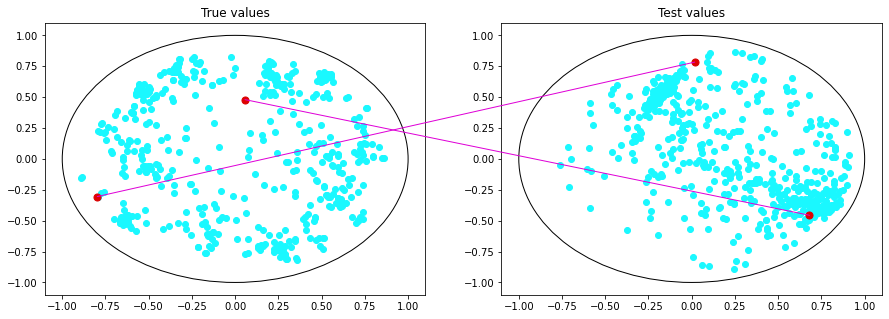

In [9]:
checking = ParticleDataset('data/test','background')
data = checking.__getitem__(1)

PATH = 'scripts/lightning/m_local_agg_6knn.ckpt'
model = model_load(PATH)
#output = hyper_gcn(data)
output = model(data)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()
ax[0].scatter(data.y[:,0],data.y[:,1],alpha=1,color='#1AF8FF')
ax[0].set_title('True values')

test = output.detach().clone()
ax[1].scatter(test[:,0],test[:,1],alpha=1,color='#1AF8FF')
ax[1].set_title('Test values')

disk = Circle((0,0),1,color='black',fill=False)
disk2 = Circle((0,0),1,color='black',fill=False)

ax[0].add_patch(disk)
ax[1].add_patch(disk2)

idxs = [0,1]
for idx00 in idxs:
    xy_left = data.y[idx00]
    xy_right = test[idx00]

    ax[0].scatter(xy_left[0],xy_left[1],alpha=1,color='#DF0101',s = 50)
    ax[1].scatter(xy_right[0],xy_right[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_left, coordsA=ax[0].transData,xyB=xy_right, coordsB=ax[1].transData,color='#DF01D7')
    fig.add_artist(con)

plt.show()

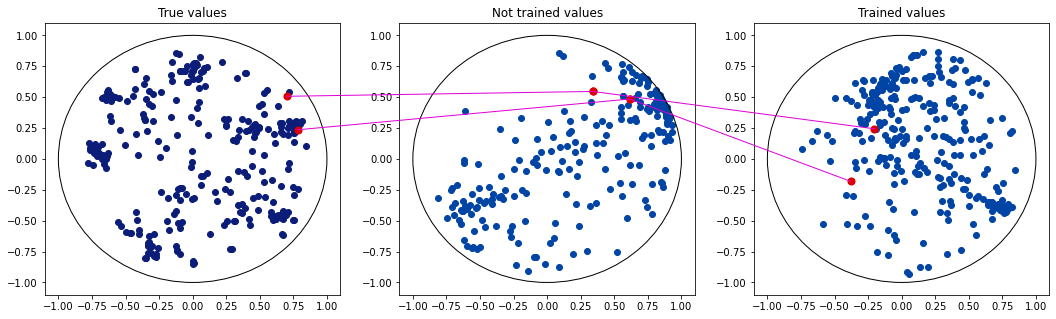

In [11]:
checking = ParticleDataset('data/background','background')
data = checking.__getitem__(1)

PATH = 'scripts/lightning/m_local_agg_6knn.ckpt'
model = model_load(PATH)
output = hyper_gcn(data)
output2 = model(data)

fig,ax = plt.subplots(1,3,figsize=(18,5))
ax = ax.flatten()
ax[0].scatter(data.y[:,0],data.y[:,1],alpha=1,color='#0b1d78')
ax[0].set_title('True values')

test = output.detach().clone()
ax[1].scatter(test[:,0],test[:,1],alpha=1,color='#0045a5')
ax[1].set_title('Not trained values')

test2 = output2.detach().clone()
ax[2].scatter(test2[:,0],test2[:,1],alpha=1,color='#0045a5')
ax[2].set_title('Trained values')


for i in range(3):
    disk = Circle((0,0),1,color='black',fill=False)
    ax[i].add_patch(disk)

    
idxs = [0,1]
for idx00 in idxs:
    xy_left = data.y[idx00]
    xy_right = test[idx00]

    ax[0].scatter(xy_left[0],xy_left[1],alpha=1,color='#DF0101',s = 50)
    ax[1].scatter(xy_right[0],xy_right[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_left, coordsA=ax[0].transData,xyB=xy_right, coordsB=ax[1].transData,color='#DF01D7')
    fig.add_artist(con)
    
    xy_right2 = test2[idx00]
    ax[1].scatter(xy_right[0],xy_right[1],alpha=1,color='#DF0101',s = 50)
    ax[2].scatter(xy_right2[0],xy_right2[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_right, coordsA=ax[1].transData,xyB=xy_right2, coordsB=ax[2].transData,color='#DF01D7')
    fig.add_artist(con)

    
plt.show()

# Do the single value decomposition to check 
# if the highest eigenvalue is less than one

In [40]:
data = checking.__getitem__(0)
matrix = HypGCN(manifold, 3, 2).double()           
x = manifold.lorentz_to_poincare(data.x[:2])

a,b = x[0], x[1]
x_ = matrix(x, data.edge_index)

print(' THE DISTANCE IN PRESERVED AFTER TRANSFORMATION:')
manifold.distance(a,b), manifold.distance(x[0],x[1])

 THE DISTANCE IN PRESERVED AFTER TRANSFORMATION:


(tensor(6.1935, dtype=torch.float64), tensor(6.1935, dtype=torch.float64))

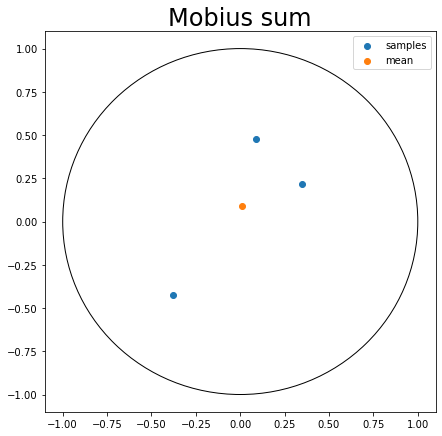

In [39]:
fig, ax = plt.subplots(figsize=(7,7))
q = torch.tensor([[ 0.3451,  0.2152],
        [ 0.0890,  0.4795],
        [-0.3796, -0.4241]])

ax.scatter(q[:,0],q[:,1],label='samples')

log = manifold.logmap(q)
mean = torch.mean(log,axis=0)
exp = manifold.expmap(mean)[0]
ax.scatter(exp[0],exp[1],label='mean')

disk = Circle((0,0),1,color='black',fill=False)

ax.add_patch(disk)
ax.legend()
ax.set_title('Mobius sum',fontsize=24)
plt.show()

In [60]:
def matrix_dist(nodes):
    matrix = torch.zeros(len(nodes),len(nodes))
    for n_idx in range(len(nodes)):
        matrix[n_idx] = manifold.distance(torch.unsqueeze(nodes[n_idx],0),nodes) + 1e-8
    return matrix

sig = torch.nn.Sigmoid()

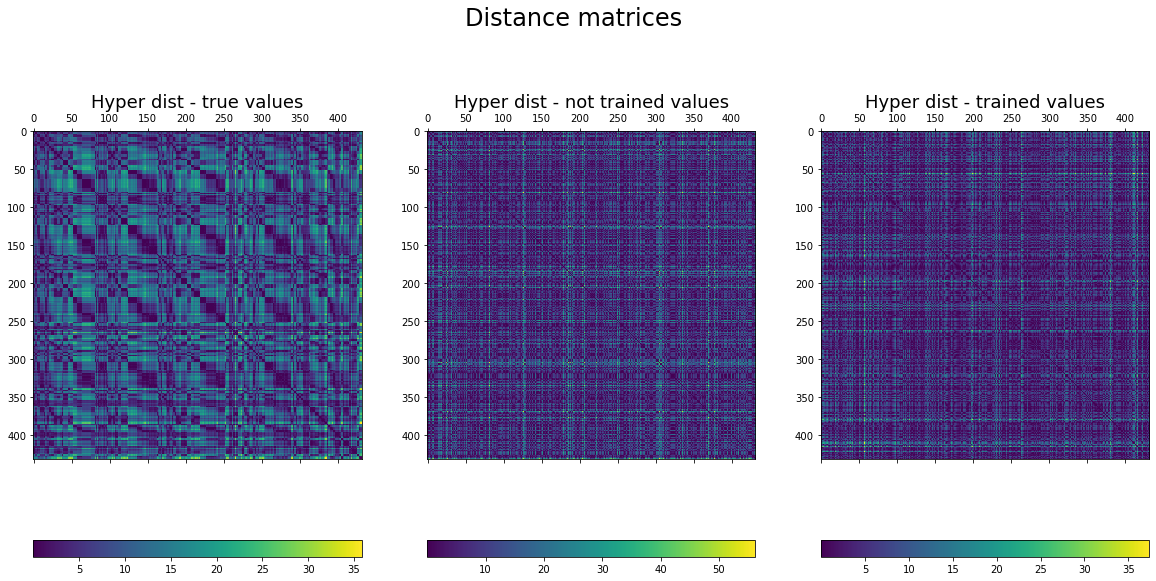

In [18]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax = ax.flatten()

PATHs = 'scripts/lightning/m_localagg_2.ckpt'

distance_y = matrix_dist(data.y)**2
pos = ax[0].matshow(distance_y)
fig.colorbar(pos, ax=ax[0], orientation='horizontal')
ax[0].set_title('Hyper dist - true values',fontsize=18)

model = model_load(PATH)
output = model(data)
distance_x = matrix_dist(output).detach()**2
pos = ax[2].matshow(distance_x)
fig.colorbar(pos, ax=ax[2], orientation='horizontal')
ax[2].set_title(f'Hyper dist - trained values', fontsize=18)

#model = model_load(PATH)
output = hyper_gcn(data)
distance_x = matrix_dist(output).detach()**2
pos = ax[1].matshow(distance_x)
fig.colorbar(pos, ax=ax[1], orientation='horizontal')
ax[1].set_title(f'Hyper dist - not trained values', fontsize=18)
#pos = ax[2].matshow(torch.abs(distance_y - distance_x))
#fig.colorbar(pos, ax=ax[2], aspect=5)  

fig.suptitle('Distance matrices',fontsize=24)
plt.show()

# Attention

In [37]:
class DenseAtt(torch.nn.Module):
    def __init__(self, in_features, dropout):
        super(DenseAtt, self).__init__()
        self.dropout = dropout
        self.linear = torch.nn.Linear(2 * in_features, 1, bias=True)
        self.in_features = in_features

    def forward (self, x, adj):
        n = x.size(0)
        # n x 1 x d
        x_left = torch.unsqueeze(x, 1)
        x_left = x_left.expand(-1, n, -1)
        # 1 x n x d
        x_right = torch.unsqueeze(x, 0)
        x_right = x_right.expand(n, -1, -1)

        x_cat = torch.cat((x_left, x_right), dim=2)
        att_adj = self.linear(x_cat).squeeze()
        att_adj = torch.sigmoid(att_adj)
        att_adj = torch.mul(adj, att_adj)
        return att_adj

class HypAgg(torch.nn.Module):
    """
    Hyperbolic aggregation layer.
    """

    def __init__(self, manifold, in_features, local_agg=None):
        super(HypAgg, self).__init__()
        self.manifold = manifold
        self.in_features = in_features
        self.local_agg = local_agg
        self.att = DenseAtt(in_features, dropout=0)

    def forward(self, x, adj):
        x_tangent = self.manifold.logmap(x)
        adj_att = self.att(x_tangent, adj)
        neighbors = torch.sum(adj, axis=-1).view(-1,1)
        support_t = torch.matmul(adj_att, x_tangent) / neighbors
        output = self.manifold.proj(self.manifold.expmap(support_t))
        return output
    
attention = HypAgg(manifold, 2).double()

# Max pooling

In [65]:
from layers.hyp_layer import HyperbolicLinear
from torch_geometric.utils import to_dense_adj
linear = HyperbolicLinear(manifold, 3, 64).double()
x, edge_index = manifold.lorentz_to_poincare(data.x), data.edge_index
adj = to_dense_adj(edge_index)[0]

In [66]:
res = linear.forward(x)

In [67]:
norms = torch.linalg.norm(res, axis=-1)
norms.shape

torch.Size([399])

In [70]:
p = 5
a = res[p]
b = res[adj[p] > 0][torch.argmin(norms[adj[p] > 0])]
torch.linalg.norm(a), torch.linalg.norm(b)

(tensor(0.9984, dtype=torch.float64, grad_fn=<CopyBackwards>),
 tensor(0.3839, dtype=torch.float64, grad_fn=<CopyBackwards>))

In [71]:
c = manifold.mobius_add(a,b)
torch.linalg.norm(c)

tensor(0.9993, dtype=torch.float64, grad_fn=<CopyBackwards>)

## Understanding the optimizer

In [21]:
def _lambda_x(x, c=1):
    x_sqnorm = torch.sum(x.data.pow(2), dim=-1, keepdim=True)
    return 2 / (1. + c * x_sqnorm).clamp_min(1e-15)

def expmap0(u, c=1):
    min_norm = 1e-15
    sqrt_c = c ** 0.5
    u_norm = torch.clamp_min(u.norm(dim=-1, p=2, keepdim=True), min_norm)
    gamma_1 = torch.tanh(sqrt_c * u_norm) * u / (sqrt_c * u_norm)
    return gamma_1

def logmap0(p, c=1):
    sqrt_c = c ** 0.5
    p_norm = p.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
    scale = 1. / sqrt_c * torch.arctanh(sqrt_c * p_norm) / p_norm
    return scale * p

def mobius_add(x, y, c=1, dim=-1):
    x2 = x.pow(2).sum(dim=dim, keepdim=True)
    y2 = y.pow(2).sum(dim=dim, keepdim=True)
    xy = (x * y).sum(dim=dim, keepdim=True)
    num = (1 + 2 * c * xy + c * y2) * x + (1 - c * x2) * y
    denom = 1 + 2 * c * xy + c ** 2 * x2 * y2
    return num / denom.clamp_min(1e-15)

def expmap(u, p, c=1):
    sqrt_c = c ** 0.5
    u_norm = u.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
    lam = _lambda_x(p, c)
    second_term = (
            torch.tanh(sqrt_c / 2 * lam * u_norm)
            * u
            / (sqrt_c * u_norm)
    )
    gamma_1 = mobius_add(p, second_term, c)
    return gamma_1

def logmap(p1, p2, c=1):
    sub = mobius_add(-p1, p2, c)
    sub_norm = sub.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
    lam = _lambda_x(p1, c)
    sqrt_c = c ** 0.5
    return 2 / sqrt_c / lam * torch.arctanh(sqrt_c * sub_norm) * sub / sub_norm

def mobius_matvec(m, x, c=1):
    sqrt_c = c ** 0.5
    x_norm = x.norm(dim=-1, keepdim=True, p=2).clamp_min(1e-15)
    mx = x @ m.transpose(-1, -2)
    mx_norm = mx.norm(dim=-1, keepdim=True, p=2).clamp_min(1e-15)
    res_c = torch.tanh(mx_norm / x_norm * torch.arctanh(sqrt_c * x_norm)) * mx / (mx_norm * sqrt_c)
    cond = (mx == 0).prod(-1, keepdim=True, dtype=torch.uint8)
    res_0 = torch.zeros(1, dtype=res_c.dtype, device=res_c.device)
    res = torch.where(cond, res_0, res_c)
    return res

In [22]:
a = torch.rand(10,2)/3
b = torch.rand(64,2)/3
any(torch.linalg.norm(a, axis=-1) > 0.9), any(torch.linalg.norm(b, axis=-1) >0.9)

(False, False)

In [23]:
%%timeit
x, adj = manifold.lorentz_to_poincare(data.x), to_dense_adj(data.edge_index)[0].double()
x_local_agg = []
y = torch.Tensor(x.shape)
for i in range(len(x)):
    x_local_agg.append(expmap(torch.mm(adj[i].view(1,-1),logmap(x[i],x)), x[i]))

torch.cat(x_local_agg, out=y)
#print(f'first row: {y[0]}')

207 ms ± 7.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
x, adj = manifold.lorentz_to_poincare(data.x), to_dense_adj(data.edge_index)[0].double()
x_local_agg = []
y = torch.Tensor(x.shape)
for i in range(1):
    print(manifold.expmap(torch.mm(adj[i].view(1,-1),manifold.logmap(x,x[i])), x[i]))
    x_local_agg.append(manifold.expmap(torch.mm(adj[i].view(1,-1),manifold.logmap(x,x[i])), x[i]))

#torch.cat(x_local_agg, out=y)
#print(f'first row: {y[0]}')

tensor([[-0.9841, -0.0794, -0.1592]], dtype=torch.float64)


In [25]:
x, adj = manifold.lorentz_to_poincare(data.x), to_dense_adj(data.edge_index)[0].double()
adj_mask = adj>0
x_local_agg2 = []
for i in range(len(x)):
    x_local_agg2.append(
        manifold.expmap(
            torch.sum(
                manifold.logmap(x[adj_mask[i]],x[i]), axis=0), x[i]).view(1,-1))

y = torch.cat(x_local_agg2)
print(f'first row: {y[0]}')

first row: tensor([-0.9841, -0.0794, -0.1592], dtype=torch.float64)


In [26]:
mask = adj[0] > 0
y_mask = data.y[mask]
distances = manifold.distance(data.y[1], data.y[2:])

In [40]:
ints = torch.randint(0,5,(2,5))

In [41]:
data.y[ints], data.y[:6], ints

(tensor([[[-0.4903,  0.3318],
          [-0.4903,  0.3318],
          [-0.5949,  0.2427],
          [-0.5097,  0.2816],
          [ 0.3378,  0.3295]],
 
         [[-0.5949,  0.2427],
          [ 0.4285,  0.3441],
          [-0.5097,  0.2816],
          [-0.4903,  0.3318],
          [-0.4903,  0.3318]]], dtype=torch.float64),
 tensor([[-0.5097,  0.2816],
         [-0.4903,  0.3318],
         [-0.5949,  0.2427],
         [ 0.3378,  0.3295],
         [ 0.4285,  0.3441],
         [-0.6253,  0.0591]], dtype=torch.float64),
 tensor([[1, 1, 2, 0, 3],
         [2, 4, 0, 1, 1]]))

In [43]:
manifold.distance(data.y[ints[0]], data.y[ints])

tensor([[1.4142e-04, 1.4142e-04, 1.4142e-04, 1.4142e-04, 1.4142e-04],
        [4.4131e-01, 2.2347e+00, 2.9940e-01, 1.6424e-01, 1.9876e+00]],
       dtype=torch.float64)

In [44]:
manifold.distance(data.y[ints[0]], data.y[ints[0]]), manifold.distance(data.y[ints[0]], data.y[ints[1]])

(tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001], dtype=torch.float64),
 tensor([0.4413, 2.2347, 0.2994, 0.1642, 1.9876], dtype=torch.float64))

In [69]:
m = matrix_dist(nodes)
indices = torch.argsort(m, axis=-1)

In [74]:
pos = indices[:,1]
neg = indices[:,1:]
pos,neg

(tensor([1, 0, 0, 4, 3]),
 tensor([[1, 2, 3, 4],
         [0, 2, 3, 4],
         [0, 1, 3, 4],
         [4, 1, 0, 2],
         [3, 1, 0, 2]]))

In [91]:
neg, neg[rd]

(tensor([[1, 2, 3, 4],
         [0, 2, 3, 4],
         [0, 1, 3, 4],
         [4, 1, 0, 2],
         [3, 1, 0, 2]]),
 tensor([[[4, 1, 0, 2],
          [0, 2, 3, 4],
          [0, 1, 3, 4],
          [1, 2, 3, 4],
          [0, 2, 3, 4]],
 
         [[1, 2, 3, 4],
          [4, 1, 0, 2],
          [1, 2, 3, 4],
          [4, 1, 0, 2],
          [1, 2, 3, 4]]]))

In [89]:
rd = torch.randint(0, 4, (2,5))

In [92]:
neg[rd][0]

tensor([[4, 1, 0, 2],
        [0, 2, 3, 4],
        [0, 1, 3, 4],
        [1, 2, 3, 4],
        [0, 2, 3, 4]])

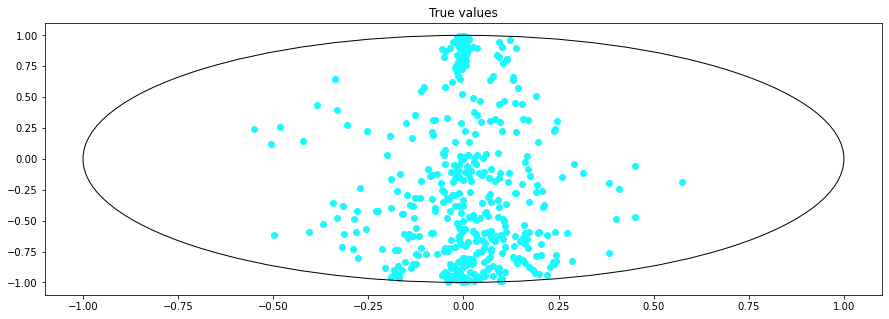

In [9]:
checking = ParticleDataset('data/test','background')
data = checking.__getitem__(1)
x = manifold.lorentz_to_poincare(data.x)

fig,ax = plt.subplots(figsize=(15,5))
ax.scatter(x[:,0],x[:,1],alpha=1,color='#1AF8FF')
ax.set_title('True values')


disk = Circle((0,0),1,color='black',fill=False)

ax.add_patch(disk)

plt.show()

In [16]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')


Processing...
Done!


In [20]:
a = dataset.__getitem__(0)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])